The purpose of this lecture is to introduce the concept of recurrent neural networks which explicity model the time-dependency of its input to enable the analysis of sequential data. We will demonstrate this functionality using a weather forecasting dataset in classic time-series analysis fashion. 


In [1]:
import deeplay as dl
import os
import torch

Here, we use the Jena Climate Dataset https://www.bgc-jena.mpg.de/wetter/

In [2]:
#data_directory = '/content/weather/' #if on Colab
#file_name = os.path.join(data_directory, 'jena_climate_2009_2016.csv')

file_name=os.path.join('.', 'jena_climate_2009_2016.csv')
with open(file_name) as file:
  data = file.read()
  lines = data.split('\n')
  header = lines[0].split(',')
  lines = lines[1:]

print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


Now, let us visualize the 14 measured features of the dataset. 


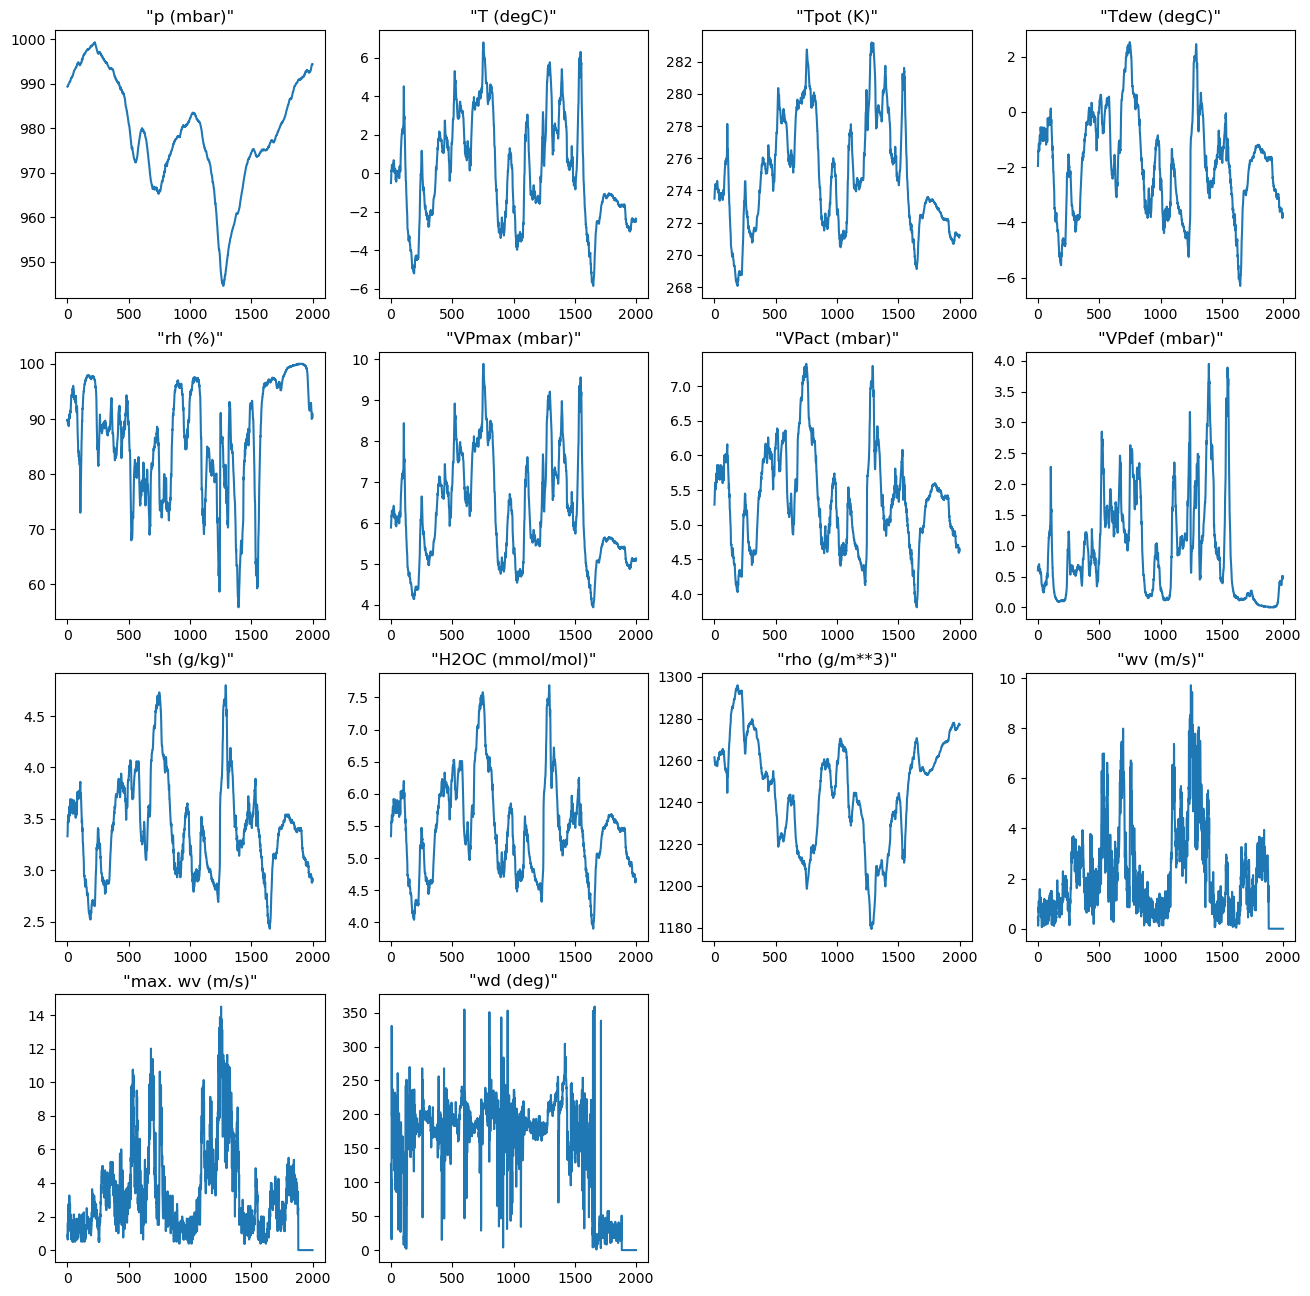

In [3]:
import numpy as np
import matplotlib.pyplot as plt

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i, :] = values

plt.figure(figsize=(16,16))
for i in range(0,float_data.shape[-1]):
  plt.subplot(4,4,i+1)
  plt.plot(float_data[2000:4000,i])
  plt.title(header[i+1])

Now, let's pre-process the data into time series to input into the model, meaning they need to be of size (batch_size,time_steps,nr_of_features).

(420451, 14)
(1641, 256, 14)
(1641, 1)


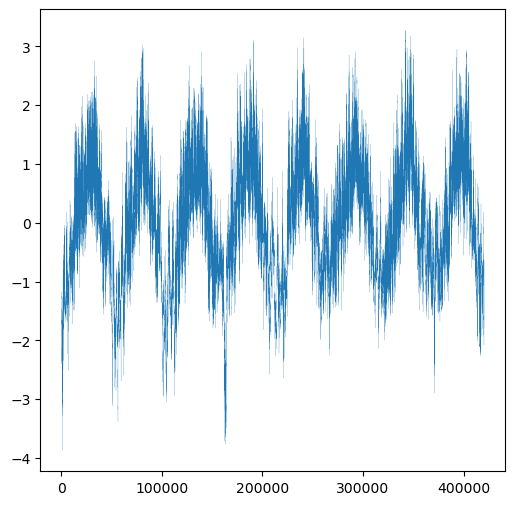

In [4]:
nr_of_features=float_data.shape[-1]
time_steps=256 #How long sequence is fed into RNN 64 used for course 
prediction_point = 64  # how many time_steps ahead in time the RNN should predict temperature. 1 very easy. 18 used for course. 144 = 1 day

mean = float_data.mean(axis=0)
float_data -= mean
std = float_data.std(axis=0)
float_data /= std

def generate_data(data,time_steps,prediction_point):
  input_data=data[:-time_steps,:]
  target_data=data[time_steps:,2]
  dataLen=input_data.shape[0] - int(input_data.shape[0] % time_steps)

  input_data=input_data[:dataLen]
  target_data=target_data[:dataLen]
  input_data=np.reshape(input_data,(-1,time_steps,nr_of_features))
  target_data=np.reshape(target_data,(-1,time_steps))
  target_data=target_data[:,prediction_point:prediction_point+1]

  #shuffle input and target data
  indices=np.arange(input_data.shape[0])
  np.random.shuffle(indices)
  input_data=input_data[indices]
  target_data=target_data[indices]

  return input_data,target_data

input_data,target_data=generate_data(float_data,time_steps,prediction_point)
print(float_data.shape)
print(input_data.shape)
print(target_data.shape)
plt.figure(figsize=(6,6))
plt.plot(float_data[:,2],lw=0.1)


# RNN numpy model

This example implements the feed-forward pass of a recurrent neural network in numpy. To keep things simple, we assume that $x_t$ is a scalar value containing a single feature. 


<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/develop/examples/module-examples/models_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

In [5]:
import numpy as np

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

time_series = [0, 1, 1, 2, 3, 5, 8]
state = 0

U = np.random.normal()
V = np.random.normal()
W = np.random.normal()
b = np.random.normal()

outputs = []

for t in time_series:
  hidden = sigmoid(np.dot(U,t) + np.dot(V,state)+b)
  output = sigmoid(np.dot(hidden, W))
  state=output
  outputs.append(output)

print(time_series)
print(outputs)

[0, 1, 1, 2, 3, 5, 8]
[0.4217266248444969, 0.39608551925705704, 0.3961065887460751, 0.38646930213602476, 0.3835549338598744, 0.3825186271974118, 0.38243771070714283]


# PyTorch RNN model

This example introduces the module RNN in PyTorch.

In [6]:
import torch
import torch.nn as nn

input_size = input_data.shape[-1] # Define based on your dataset
hidden_units = 2  # Example hidden units

# Define the RNN and Linear layers separately
rnn = nn.RNN(input_size=input_size, hidden_size=hidden_units, batch_first=True)
fc = nn.Linear(hidden_units, 1)

# Loss and Optimizer
criterion = nn.L1Loss()  # MAE Loss
optimizer = torch.optim.Adam(list(rnn.parameters()) + list(fc.parameters()), lr=0.001)



Current Training Loss: 0.8037 Current Validation Loss: 0.7206
Current Training Loss: 0.6841 Current Validation Loss: 0.6253
Current Training Loss: 0.6084 Current Validation Loss: 0.5693
Current Training Loss: 0.5669 Current Validation Loss: 0.5368
Current Training Loss: 0.5406 Current Validation Loss: 0.5156
Current Training Loss: 0.5232 Current Validation Loss: 0.5011
Current Training Loss: 0.5109 Current Validation Loss: 0.4909
Current Training Loss: 0.5016 Current Validation Loss: 0.4823
Current Training Loss: 0.4940 Current Validation Loss: 0.4749
Current Training Loss: 0.4874 Current Validation Loss: 0.4690
Current Training Loss: 0.4820 Current Validation Loss: 0.4646
Current Training Loss: 0.4774 Current Validation Loss: 0.4606
Current Training Loss: 0.4734 Current Validation Loss: 0.4570
Current Training Loss: 0.4695 Current Validation Loss: 0.4533
Current Training Loss: 0.4657 Current Validation Loss: 0.4495
Current Training Loss: 0.4621 Current Validation Loss: 0.4454
Current 

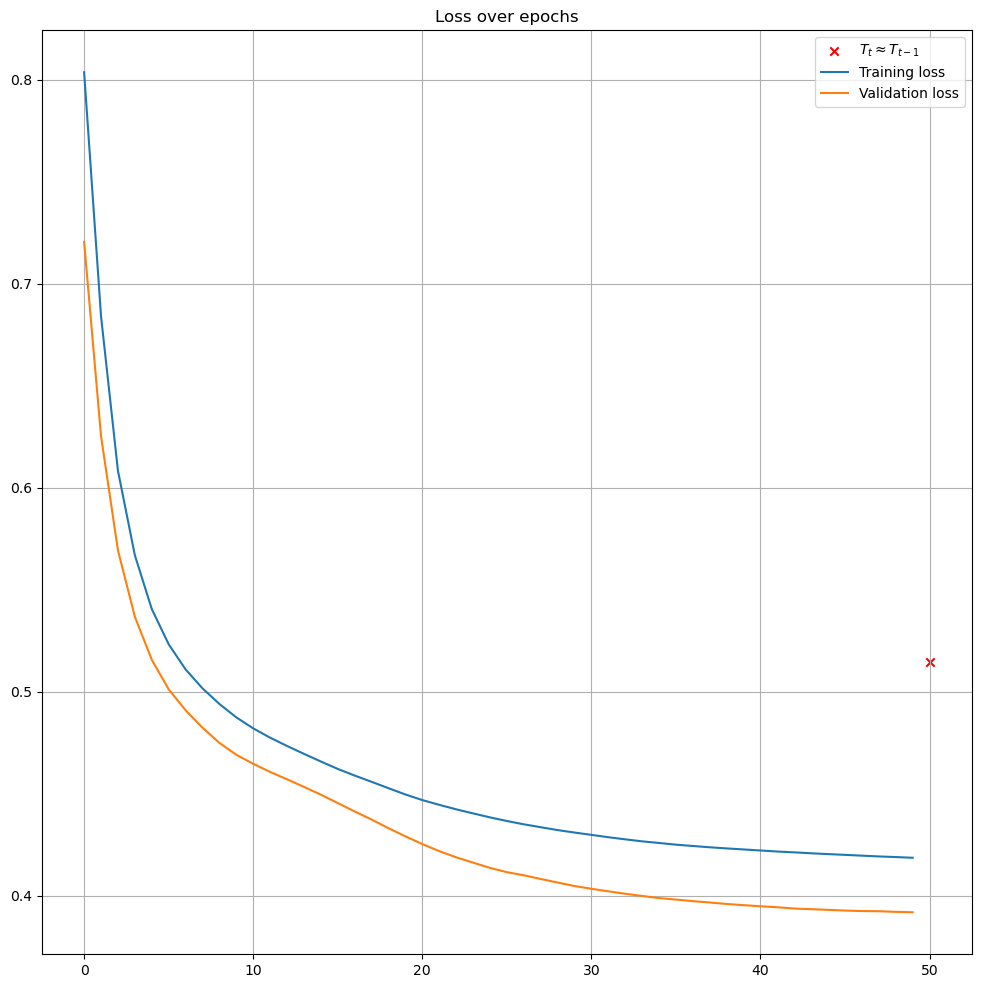

In [7]:
from torch.utils.data import random_split,TensorDataset, DataLoader

def create_data_loader(input_data, target_data, batch_size=32):

    # Convert to PyTorch tensors
    input_tensor = torch.tensor(input_data, dtype=torch.float32)
    target_tensor = torch.tensor(target_data, dtype=torch.float32)

    # Splitting the dataset into training and validation
    train_dataset = TensorDataset(input_tensor[:nr_of_sequences], target_tensor[:nr_of_sequences])
    train_dataset,val_dataset = random_split(train_dataset, [0.8, 0.2])
    # Creating data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False)

    return train_loader, val_loader

def create_benchmark(val_loader): #generate benchmark for comparison, i.e. predict T_t = T_{t-1}

    mae_benchmark=[]
    for inputs, targets in val_loader:
        val_predict_sequence = inputs[:, -1, 2]
        val_target_sequence = targets[:, 0]
        ae=torch.abs(val_predict_sequence - val_target_sequence)
        mae_benchmark.append(ae)

    mae_benchmark=torch.cat(mae_benchmark)
    mae_benchmark=torch.mean(mae_benchmark)
    return mae_benchmark

def train_model(rnn,fc, nr_of_sequences, epochs, criterion, optimizer,train_loader,val_loader):

    rnn.train()
    fc.train()
    train_losses = []
    val_losses = []

# Training Loop
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()

            # RNN layer
            rnn_out, _ = rnn(inputs)
            
            # Selecting the last output for each sequence
            rnn_out = rnn_out[:, -1, :]
            
            # Linear layer
            outputs = fc(rnn_out)
            
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Validation loop
        rnn.eval()
        fc.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                # RNN layer
                rnn_out, _ = rnn(inputs)
                
                # Selecting the last output for each sequence
                rnn_out = rnn_out[:, -1, :]
                
                # Linear layer
                outputs = fc(rnn_out)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))
        print("Current Training Loss: {:.4f}".format(train_losses[-1])+ " Current Validation Loss: {:.4f}".format(val_losses[-1]))

    # Generate predictions on validation set
    with torch.no_grad():
        val_input_tensor = torch.tensor(input_data[nr_of_sequences:], dtype=torch.float32)
        val_rnn_out, _ = rnn(val_input_tensor)
        val_rnn_out = val_rnn_out[:, -1, :]
        val_predict_sequence = fc(val_rnn_out).numpy()
        val_target_sequence = target_data[nr_of_sequences:]
    return train_losses, val_losses,val_predict_sequence,val_target_sequence

import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses,mae_benchmark):
    plt.figure(figsize=(12, 12))
    plt.scatter(len(train_losses),mae_benchmark,marker='x',c='red', label=r"$T_t \approx T_{t-1}$")
    plt.plot(train_losses, label="Training loss")
    plt.plot(val_losses, label="Validation loss")
    plt.legend(loc="best")
    plt.title("Loss over epochs")
    plt.grid(True)
    plt.show()

def train_and_plot(rnn,fc, nr_of_sequences, epochs,criterion, optimizer,train_loader,val_loader):
    train_losses, val_losses,val_predict_sequence,val_target_sequence = train_model(rnn,fc, nr_of_sequences,epochs,criterion,optimizer,train_loader, val_loader)
    plot_losses(train_losses, val_losses,mae_benchmark)
    return val_predict_sequence,val_target_sequence


nr_of_sequences=1600
epochs=50
train_loader, val_loader = create_data_loader(input_data, target_data)
mae_benchmark=create_benchmark(val_loader)
val_predict_sequence,val_target_sequence = train_and_plot(rnn,fc,nr_of_sequences,epochs,criterion,optimizer,train_loader, val_loader)

We implement the RNN in deeplay.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Regressor(
  (loss): L1Loss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): RNN(
    (blocks): LayerList(
      (0): RecurrentNeuralNetwork(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): RNN(14, 2)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Drop()
          )
        )
      )
      (1): MultiLayerPerceptron(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): Linear(in_features=2, out_features=1, bias=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Dropout(p=0, inplace=False)
          )
        )
      )
    )
    (rnn): RecurrentNeuralNetwork(
      (blocks): LayerList(
        (0): LayerActivationNormalizationDropout(
          (layer

2023-12-21 19:06:59.778198: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | L1Loss           | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | RNN              | 39    
5 | optimizer     | Adam             | 0     
---------------------------------------------------
39        Trainable params
0         Non-trainable params
39        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


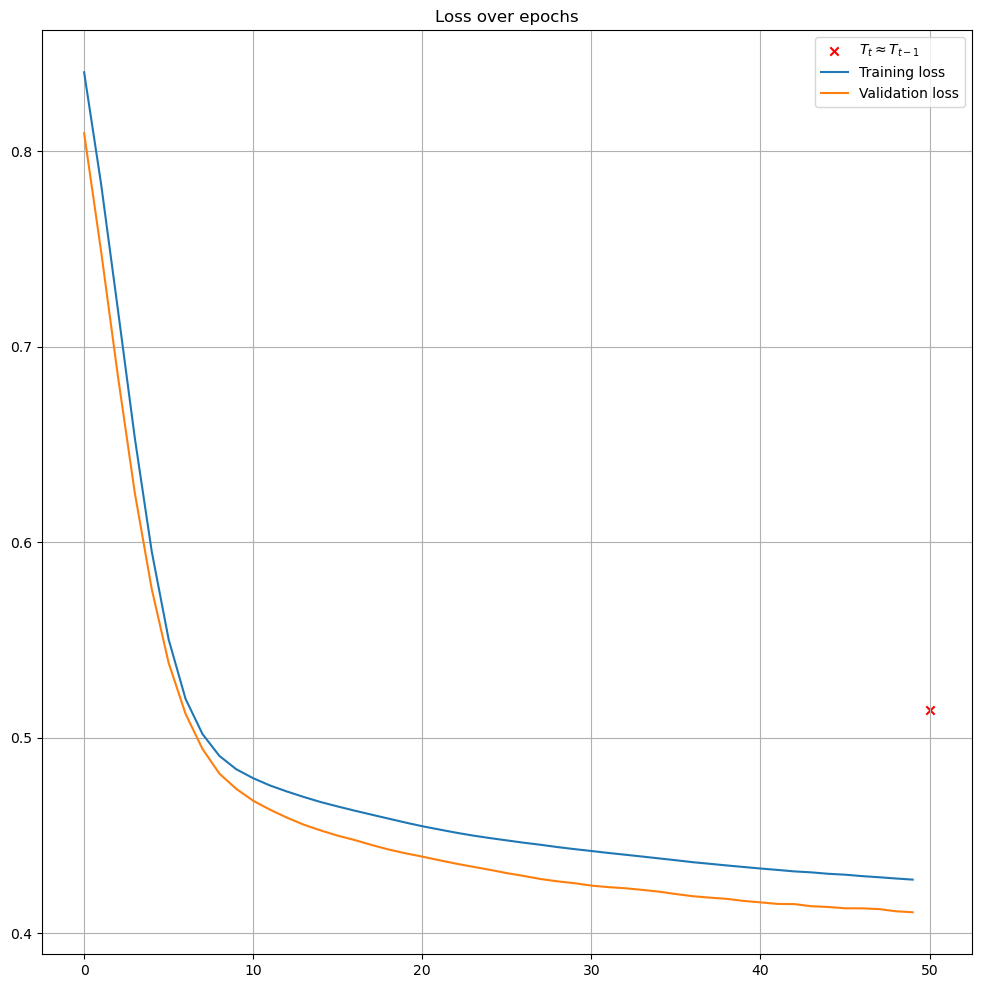

In [8]:
rnn = dl.RNN(in_features=14,hidden_features=[hidden_units],out_features=1,rnn_type="RNN")
model = dl.Regressor(rnn,optimizer=dl.Adam(lr=0.001))
model=model.create()
print(model)

from lightning.pytorch.callbacks import Callback
class LossHistory(Callback):
    def on_train_start(self, trainer, pl_module):
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics.get('train_loss')
        if train_loss is not None:
            self.train_losses.append(train_loss.item())
        val_loss = trainer.callback_metrics.get('val_loss')
        if train_loss is not None:
            self.val_losses.append(val_loss.item())

loss_history = LossHistory()
trainer = dl.Trainer(max_epochs=epochs, callbacks=[loss_history],accelerator="auto")
trainer.fit(model, train_loader,val_dataloaders=val_loader)

plot_losses(loss_history.train_losses, loss_history.val_losses,mae_benchmark)

Stacked RNN in Deeplay

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | L1Loss           | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | RNN              | 7.9 K 
5 | optimizer     | Adam             | 0     
---------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.032     Total estimated model params size (MB)


Regressor(
  (loss): L1Loss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): RNN(
    (blocks): LayerList(
      (0): RecurrentNeuralNetwork(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): RNN(14, 32)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Drop()
          )
        )
      )
      (1-3): 3 x RecurrentNeuralNetwork(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): RNN(32, 32)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Drop()
          )
        )
      )
      (4): MultiLayerPerceptron(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): Linear(in_features=32, out_features=1, bias=True

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


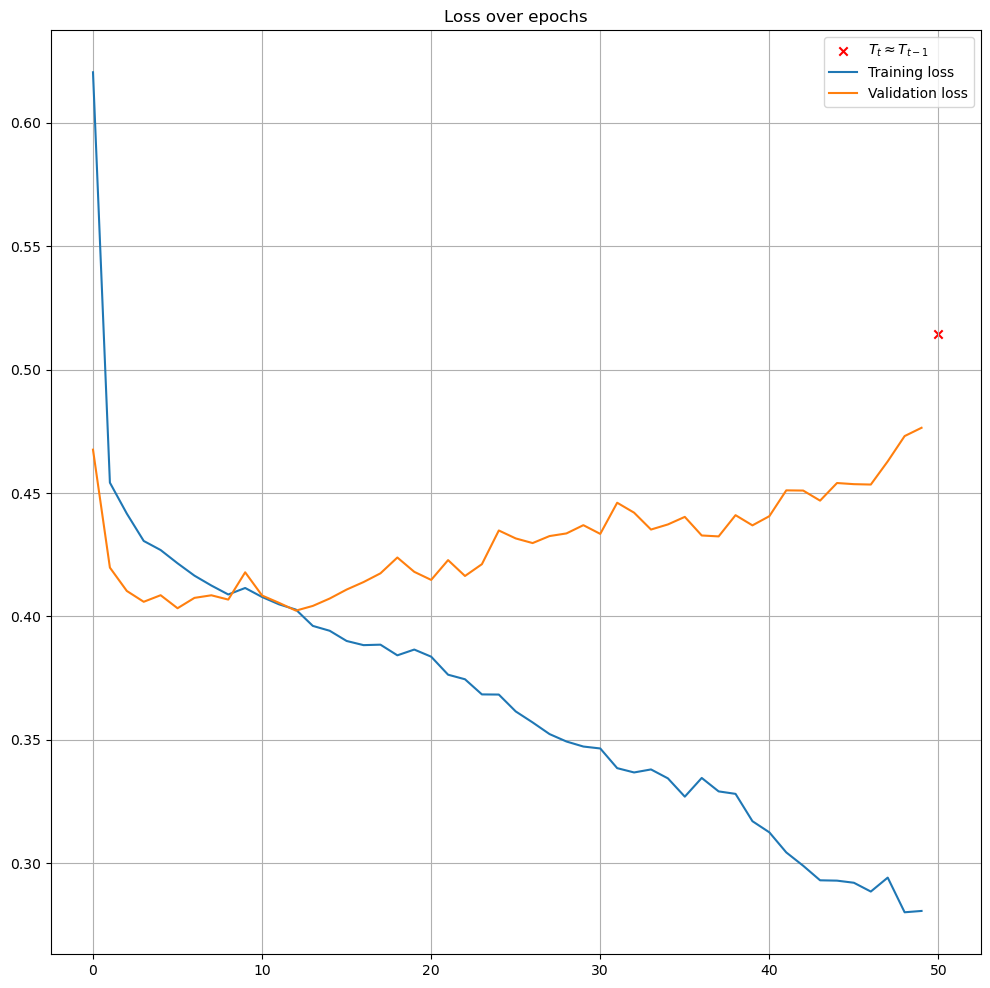

In [9]:

hidden_features=[32,32,32,32]
rnn = dl.RNN(in_features=14,hidden_features=hidden_features,out_features=1,rnn_type="RNN")
model = dl.Regressor(rnn,optimizer=dl.Adam(lr=0.001))
model=model.create()
print(model)

trainer = dl.Trainer(max_epochs=epochs, callbacks=[loss_history],accelerator="auto")
trainer.fit(model, train_loader,val_dataloaders=val_loader)
plot_losses(loss_history.train_losses, loss_history.val_losses,mae_benchmark)


Configure to stacked GRU instead

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | L1Loss           | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | RNN              | 23.6 K
5 | optimizer     | Adam             | 0     
---------------------------------------------------
23.6 K    Trainable params
0         Non-trainable params
23.6 K    Total params
0.095     Total estimated model params size (MB)


Regressor(
  (loss): L1Loss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): RNN(
    (blocks): LayerList(
      (0): RecurrentNeuralNetwork(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): GRU(14, 32)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Drop()
          )
        )
      )
      (1-3): 3 x RecurrentNeuralNetwork(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): GRU(32, 32)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Drop()
          )
        )
      )
      (4): MultiLayerPerceptron(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): Linear(in_features=32, out_features=1, bias=True

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


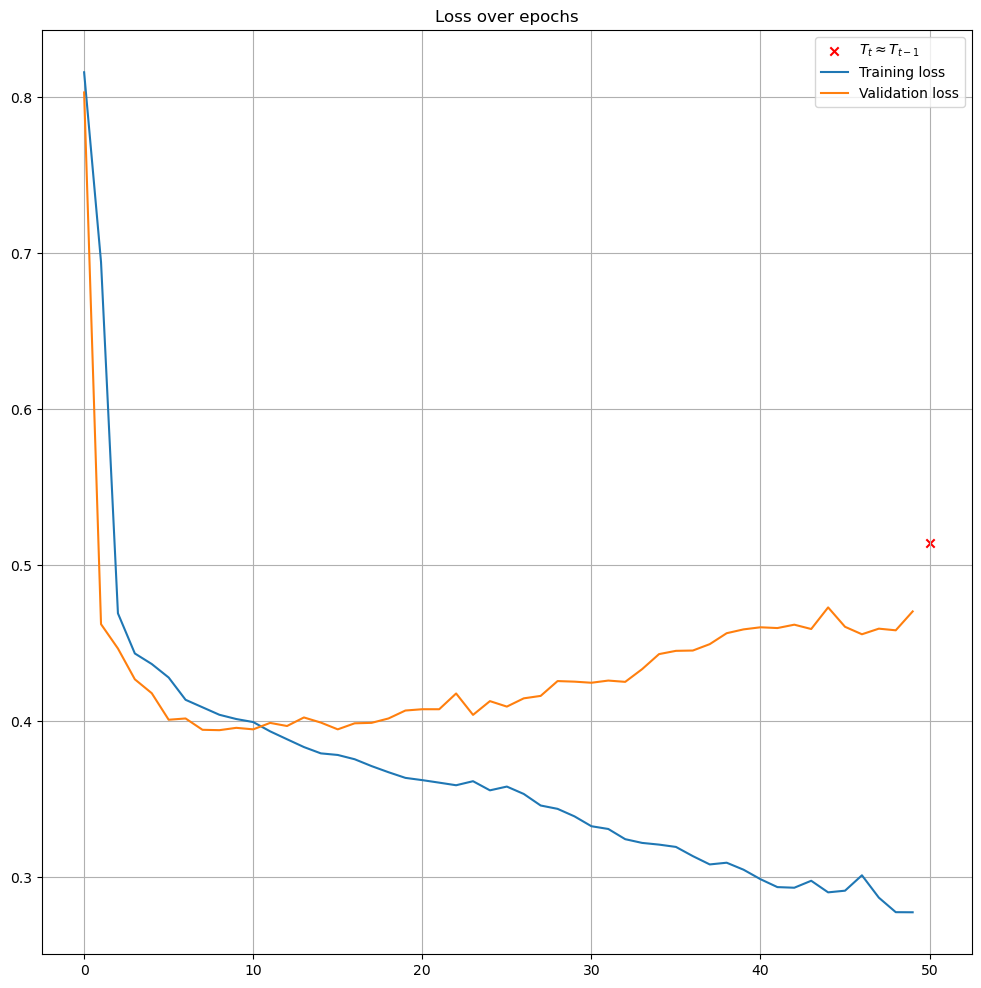

In [10]:
rnn.blocks[:-1].layer.configure(torch.nn.GRU)
model = dl.Regressor(rnn)
model=model.create()
print(model)

trainer = dl.Trainer(max_epochs=epochs, callbacks=[loss_history],accelerator="auto")
trainer.fit(model, train_loader,val_dataloaders=val_loader)

plot_losses(loss_history.train_losses, loss_history.val_losses,mae_benchmark)

Configure to stacked LSTM instead

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | L1Loss           | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | RNN              | 31.5 K
5 | optimizer     | Adam             | 0     
---------------------------------------------------
31.5 K    Trainable params
0         Non-trainable params
31.5 K    Total params
0.126     Total estimated model params size (MB)


Regressor(
  (loss): L1Loss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): RNN(
    (blocks): LayerList(
      (0): RecurrentNeuralNetwork(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): LSTM(14, 32)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Drop()
          )
        )
      )
      (1-3): 3 x RecurrentNeuralNetwork(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): LSTM(32, 32)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Drop()
          )
        )
      )
      (4): MultiLayerPerceptron(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): Linear(in_features=32, out_features=1, bias=Tr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


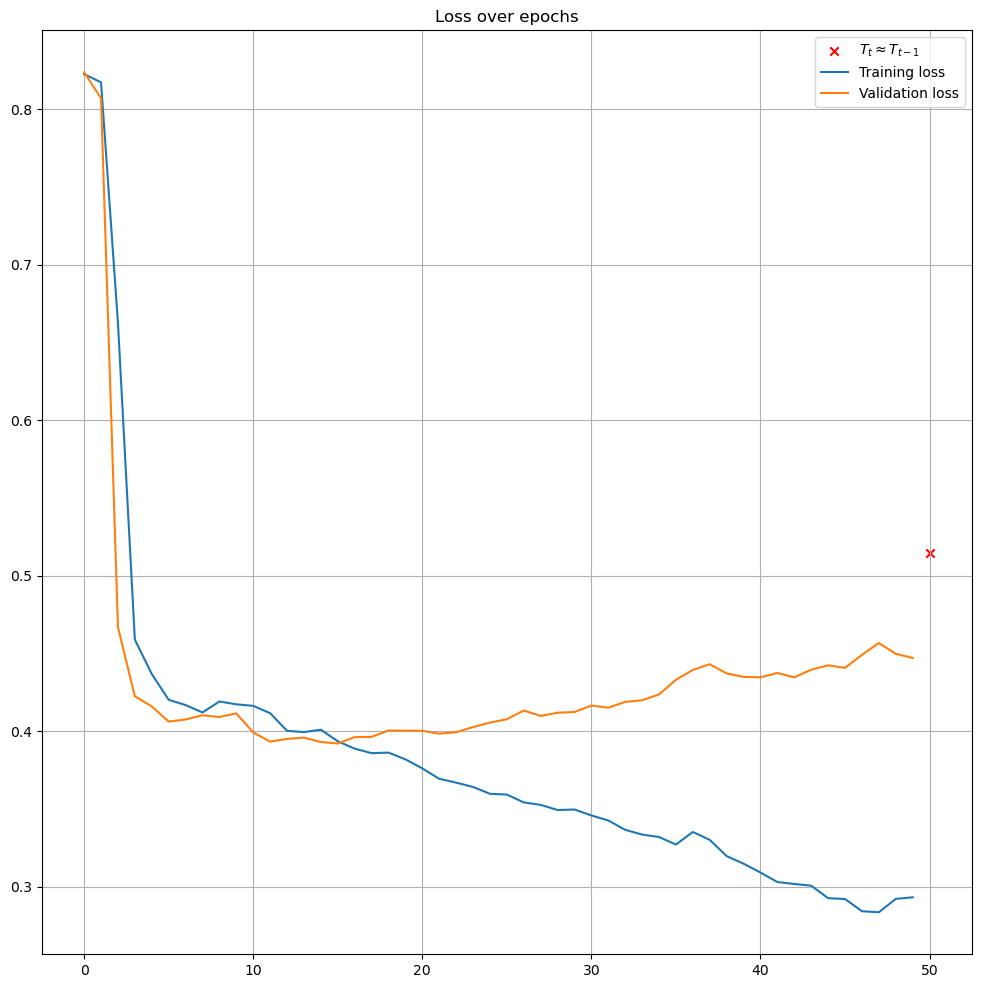

In [11]:
rnn.blocks[:-1].layer.configure(torch.nn.LSTM)
model = dl.Regressor(rnn)
model=model.create()
print(model)

trainer = dl.Trainer(max_epochs=epochs, callbacks=[loss_history],accelerator="auto")
trainer.fit(model, train_loader,val_dataloaders=val_loader)

plot_losses(loss_history.train_losses, loss_history.val_losses,mae_benchmark)

Introduce dropout to prevent overfitting

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | L1Loss           | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | RNN              | 31.5 K
5 | optimizer     | Adam             | 0     
---------------------------------------------------
31.5 K    Trainable params
0         Non-trainable params
31.5 K    Total params
0.126     Total estimated model params size (MB)


Regressor(
  (loss): L1Loss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): RNN(
    (blocks): LayerList(
      (0): RecurrentNeuralNetwork(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): LSTM(14, 32)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Drop()
          )
        )
      )
      (1-3): 3 x RecurrentNeuralNetwork(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): LSTM(32, 32)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Drop()
          )
        )
      )
      (4): MultiLayerPerceptron(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): Linear(in_features=32, out_features=1, bias=Tr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


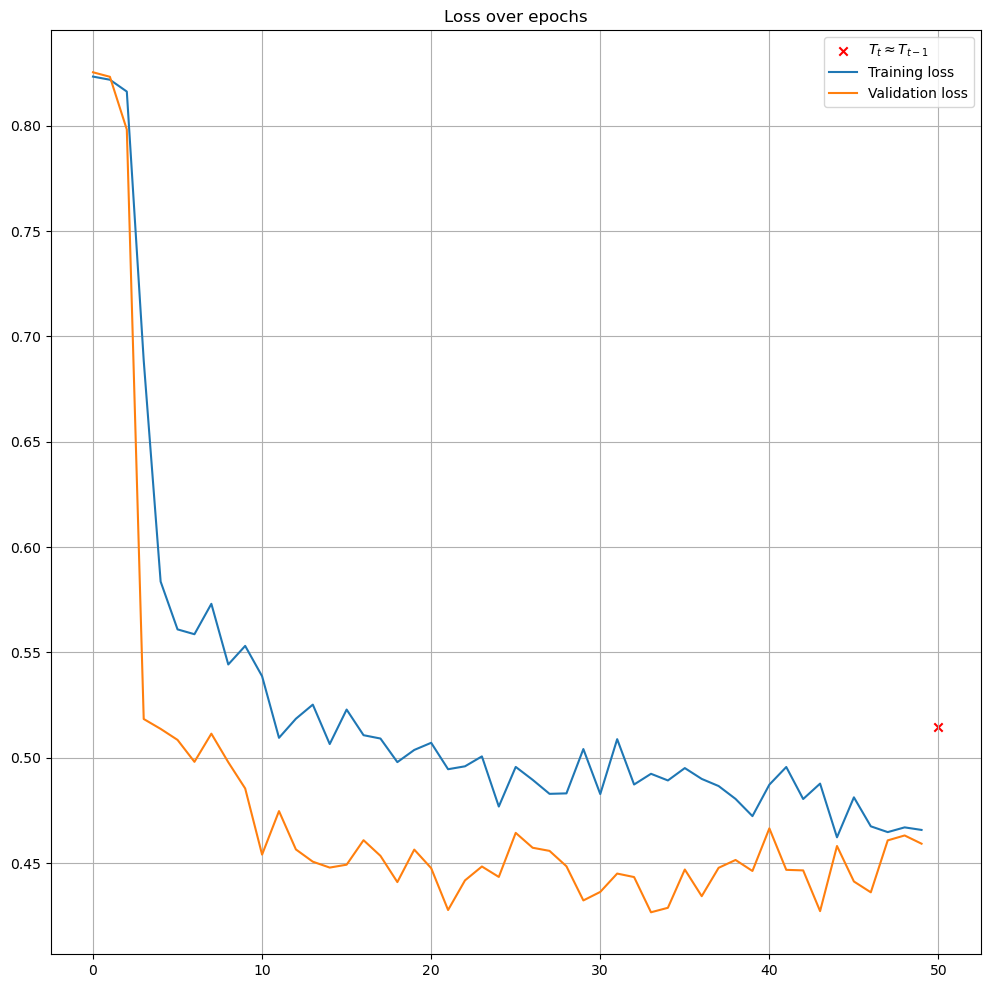

In [12]:

rnn.blocks.dropout.configure(p=0.2)
model = dl.Regressor(rnn)
model=model.create()
print(model)

trainer = dl.Trainer(max_epochs=50, callbacks=[loss_history],accelerator="auto")
trainer.fit(model, train_loader,val_dataloaders=val_loader)

plot_losses(loss_history.train_losses, loss_history.val_losses,mae_benchmark)

Introduce dense preprocessor in feature space

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | L1Loss           | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | Sequential       | 10.6 K
5 | optimizer     | Adam             | 0     
---------------------------------------------------
10.6 K    Trainable params
0         Non-trainable params
10.6 K    Total params
0.042     Total estimated model params size (MB)


Regressor(
  (loss): L1Loss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): Sequential(
    (0): Flatten(start_dim=0, end_dim=1)
    (1): MultiLayerPerceptron(
      (blocks): LayerList(
        (0): LayerActivationNormalizationDropout(
          (layer): LazyLinear(in_features=0, out_features=32, bias=True)
          (activation): ReLU()
          (normalization): Identity()
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (1): LayerActivationNormalizationDropout(
          (layer): Linear(in_features=32, out_features=32, bias=True)
          (activation): ReLU()
          (normalization): Identity()
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (2): LayerActivationNormalizationDropout(
          (layer): Linear(in_features=32, out_features=32, bias=True)
          (activation): Identity()
          (normalizati

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


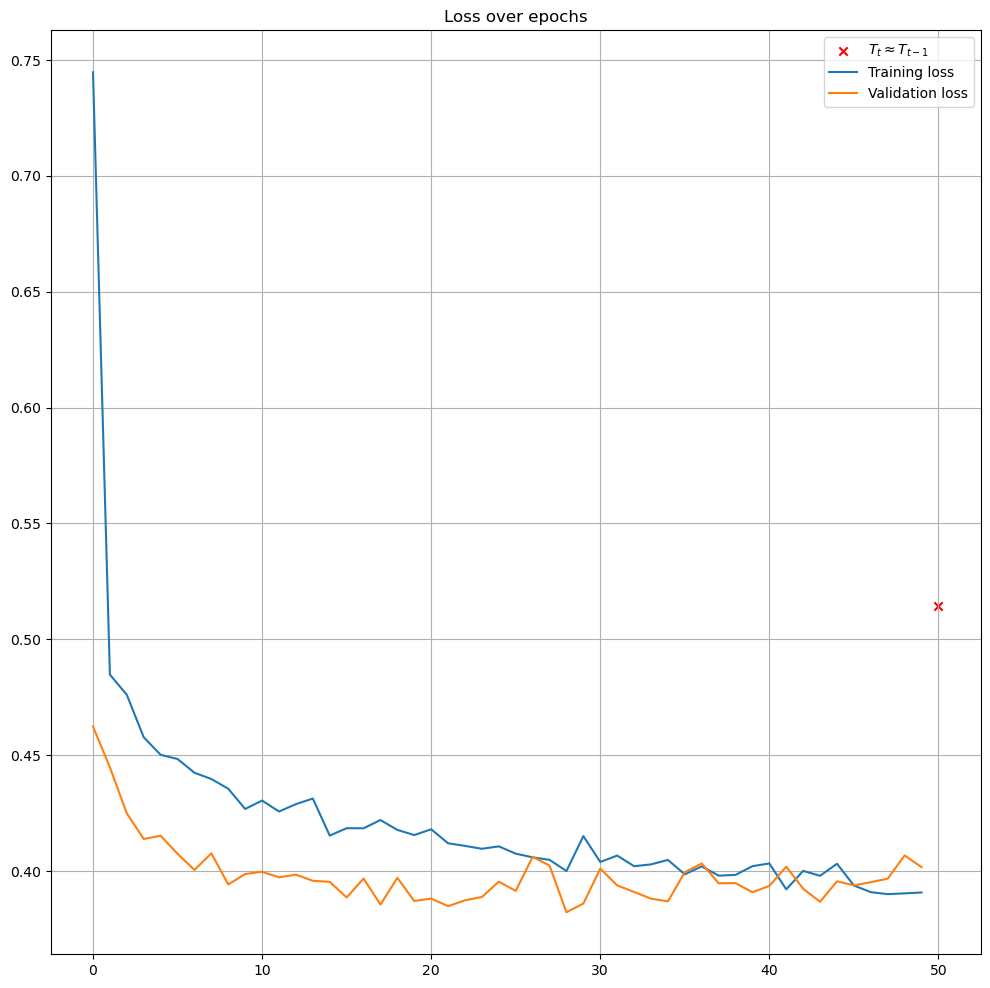

In [13]:
hidden_size=32
hidden_features=[hidden_size]*4
dense_features=[hidden_size]*2

dense_preprocessor = dl.MultiLayerPerceptron(in_features=None,hidden_features=dense_features,out_features=hidden_features[0])
dense_preprocessor.dropout.configure(p=0.2)

rnn=dl.RNN(in_features=hidden_features[0],hidden_features=hidden_features,out_features=1,dropout=0.2,rnn_type="LSTM")

# Custom Reshape Layer
class Reshape(nn.Module):
    def __init__(self, new_shape):
        super(Reshape, self).__init__()
        self.new_shape = new_shape

    def forward(self, x):
        return x.view(self.new_shape)
    
dense_rnn = dl.Sequential(torch.nn.Flatten(start_dim=0,end_dim=1),dense_preprocessor,Reshape((-1, time_steps,hidden_features[-1])),rnn)
   
model = dl.Regressor(dense_rnn) 
model=model.create()
print(model)

trainer = dl.Trainer(max_epochs=50, callbacks=[loss_history],accelerator="auto")
trainer.fit(model, train_loader,val_dataloaders=val_loader)

plot_losses(loss_history.train_losses, loss_history.val_losses,mae_benchmark)